In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

Queremos predecir (?) la longitud de las aletas.

# Data

In [3]:
df = pd.read_csv("datos/penguins.csv").dropna()
df.groupby(["species"])["flipper_length"].describe()

flipper  = df["flipper_length"].values
species = df["species"].values
species = pd.Categorical(df["species"]).codes

min_valor = 8
max_valor = 50
refs = {"Aleta pinguino azul":min_valor,
        "Aleta pingüino emperador":max_valor}

# Modelo 1: sin agrupar

Decidimos armar nuestro primer modelo sin discriminar por especie. Teniendo en cuenta los valores máximo y mínimo teóricos decidimos modelar la media como una distribución Normal con media en $\frac {emperador + azul}{2}$ y $sigma = 10$.

In [163]:
with pm.Model() as model_1:
    mu = pm.Normal("mu", mu= 29, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    y = pm.Gamma("y", mu=mu, sigma=sigma, observed=flipper)
    trace_1 = pm.sample(2000 ,chains=4, progressbar=False)
    trace_1.extend(pm.sample_prior_predictive(samples=100))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
Sampling: [mu, sigma, y]


## Prior Predictive Checks

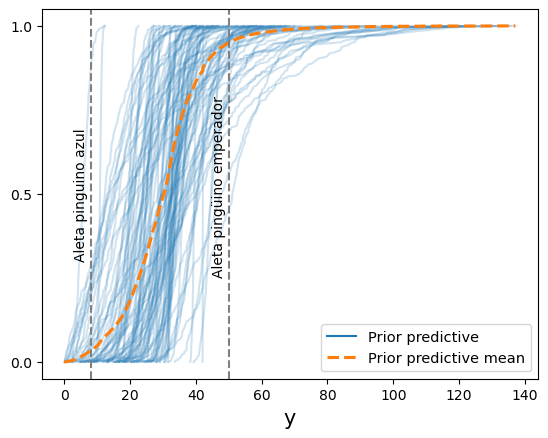

In [164]:
fig, ax = plt.subplots()
az.plot_ppc(trace_1, group="prior", kind="cumulative", ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-5, 0.5-(len(key)/100), key, rotation=90)

Como vemos que tenemos varios valores por fuera de los limites teoricos establecidos, decidimos modificar los priors para que sean menos anchos.

In [165]:
with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=29, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    y = pm.Gamma("y", mu=mu, sigma=sigma, observed=flipper)
    trace_1 = pm.sample(2000 ,chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_1.extend(pm.sample_prior_predictive(samples=100))
    trace_1.extend(pm.sample_posterior_predictive(trace_1));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
Sampling: [mu, sigma, y]
Sampling: [y]


Output()

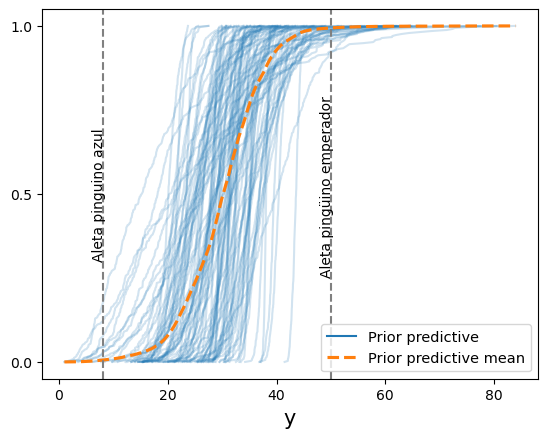

In [166]:
fig, ax = plt.subplots()
az.plot_ppc(trace_1, group="prior", kind="cumulative", ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-2, 0.5-(len(key)/100), key, rotation=90)

## Posterior Predictive Checks

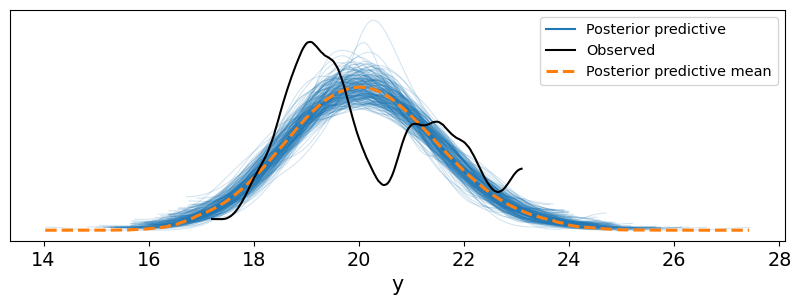

In [167]:
az.plot_ppc(trace_1, figsize=(10, 3), num_pp_samples=200);

## Diagnostico de muestreo

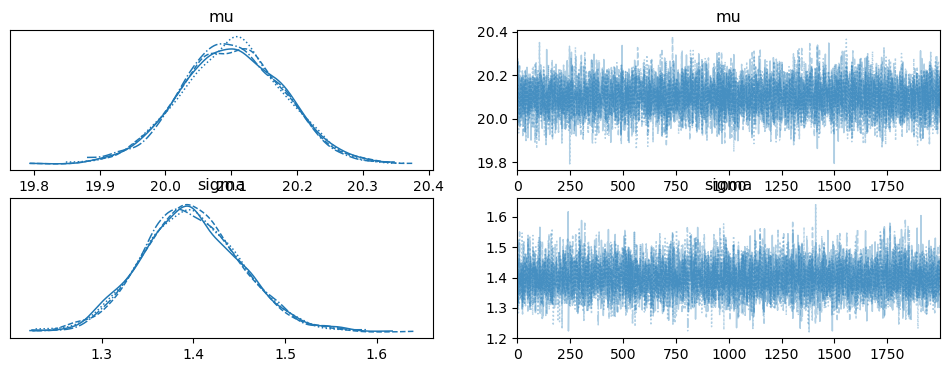

In [168]:
az.plot_trace(trace_1, var_names=["mu", "sigma"], compact=True);

In [169]:
az.rhat(trace_1, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 1.0
    sigma    float64 8B 1.001

In [170]:
az.ess(trace_1, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 7.865e+03
    sigma    float64 8B 8.133e+03

In [171]:
az.summary(trace_1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     20.101  0.077  19.958   20.246      0.001    0.001    7865.0    5190.0   
sigma   1.398  0.054   1.295    1.497      0.001    0.000    8133.0    6345.0   

       r_hat  
mu       1.0  
sigma    1.0

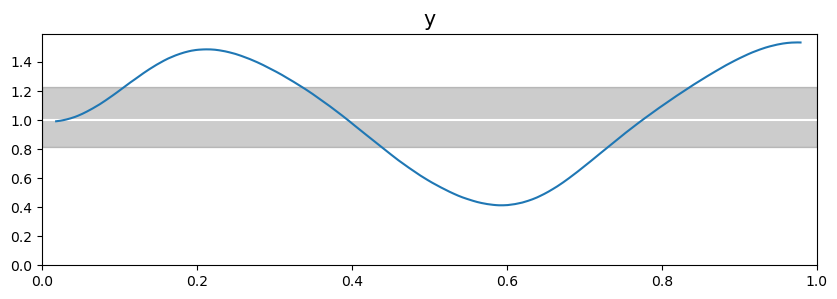

In [172]:
az.plot_bpv(trace_1, figsize=(10, 3));

La _posterior predictive_ es muy diferente a la distribución observada, igualmente consideraremos el modelo a la hora de la comparación.

# Modelo 2: agrupando por especie, no jerárquico

In [4]:
cat_encode = pd.Categorical(df['species'])
idx = cat_encode.codes
coords = {"species": cat_encode.categories, "species_flat": cat_encode.categories[idx]}

In [5]:
with pm.Model(coords=coords) as model_2:
    mu = pm.Normal("mu", mu=29, sigma=5, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")


In [6]:
with model_2:
    trace_2 = pm.sample_prior_predictive(samples=100)

Sampling: [mu, sigma, y]


## Prior Predictive Check

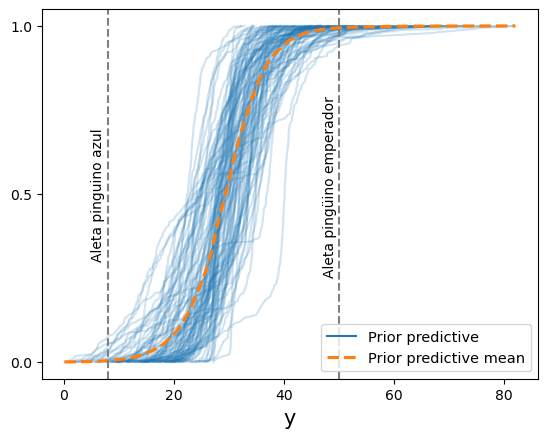

In [176]:
fig, ax = plt.subplots()
az.plot_ppc(trace_2, group="prior", kind="cumulative", ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90)

## Posterior Predictive Check

In [7]:
with model_2:
    trace_2 = pm.sample(2000 ,chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_2.extend(pm.sample_posterior_predictive(trace_2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
Sampling: [y]


Output()

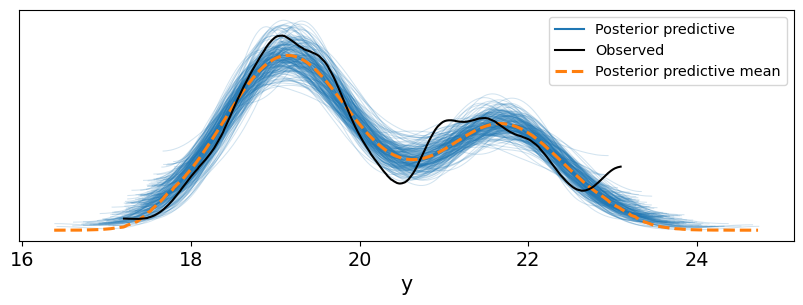

In [178]:
az.plot_ppc(trace_2, figsize=(10, 3), num_pp_samples=200);

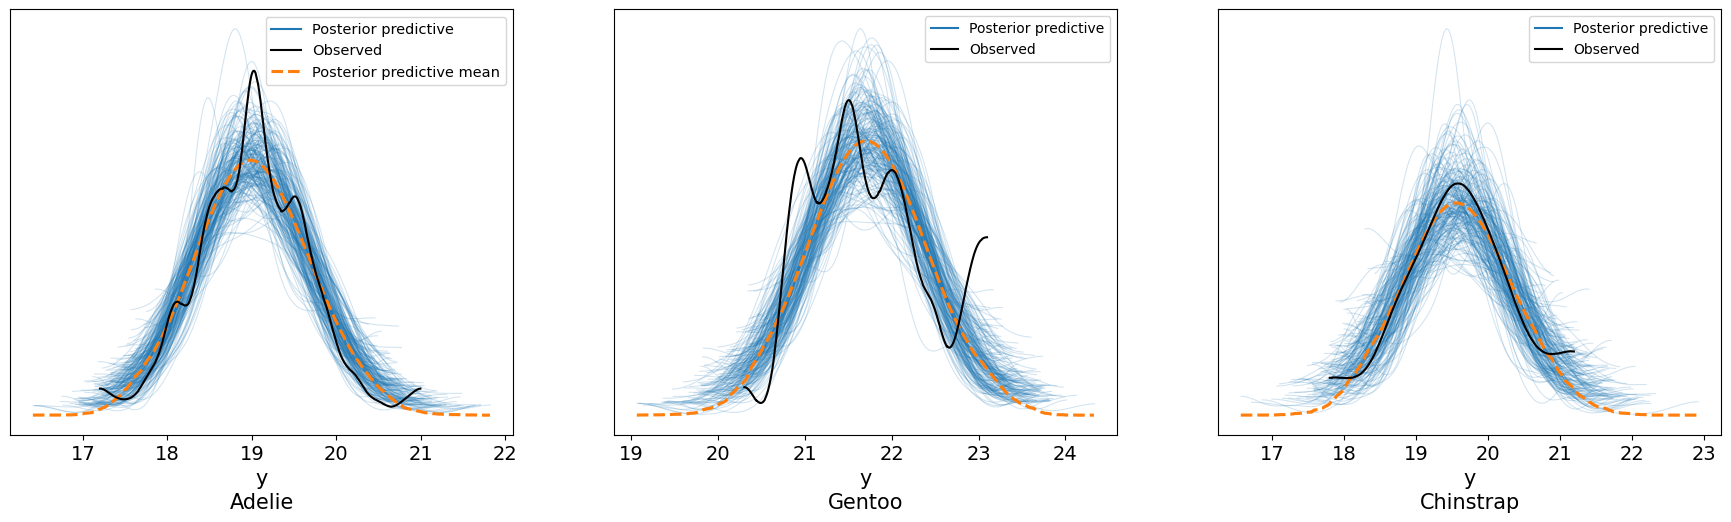

In [179]:
az.plot_ppc(trace_2, coords={"species_flat": [cat_encode.categories]}, flatten=[], num_pp_samples=200);

Este modelo captura bien las distribuciones del tamaño de las aletas diferenciando por especie

# Diagnostico de muestreo

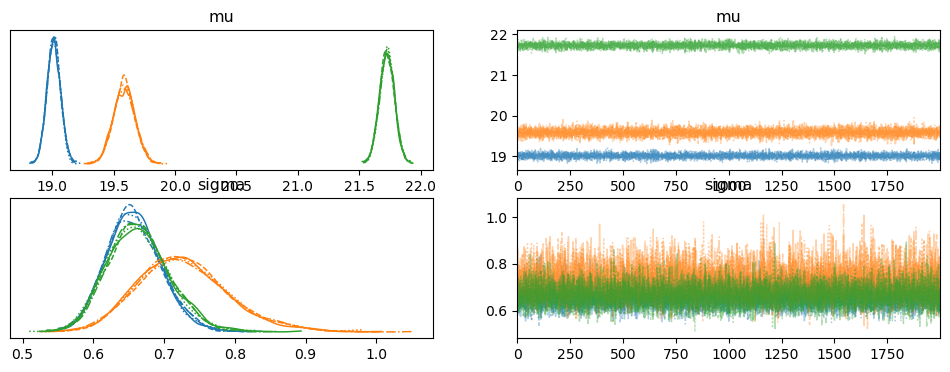

In [180]:
az.plot_trace(trace_2, var_names=["mu", "sigma"], compact=True);

In [9]:
trace_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

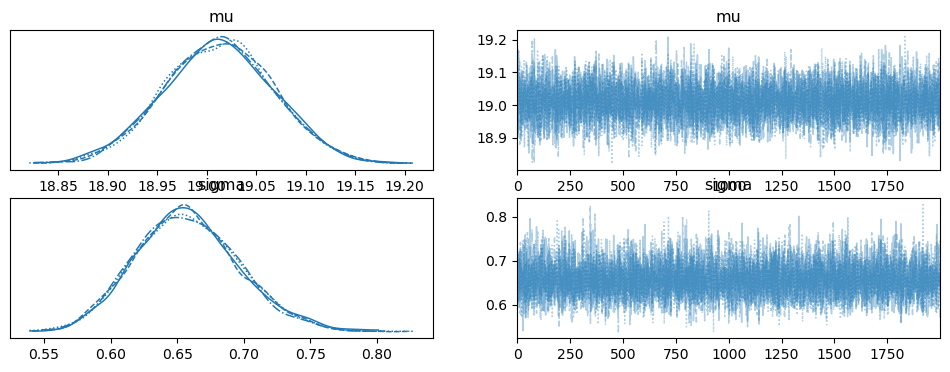

In [14]:
az.plot_trace(trace_2,var_names=["mu","sigma"],coords = {"species":["Adelie"]})

In [181]:
az.rhat(trace_2, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 0.9999 1.001 1.0
    sigma    (species) float64 24B 1.0 1.0 1.0

In [182]:
az.ess(trace_2, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 1.088e+04 1.142e+04 9.88e+03
    sigma    (species) float64 24B 1.468e+04 1.237e+04 9.519e+03

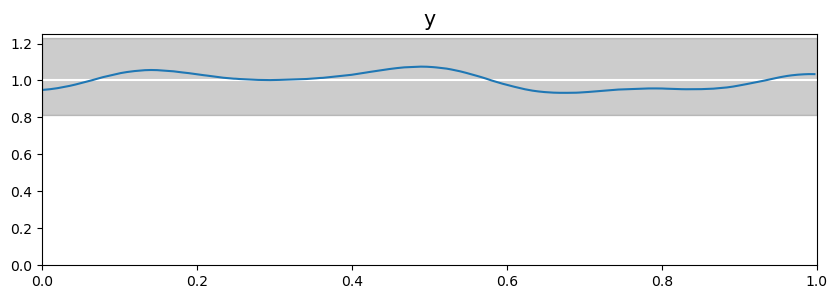

In [183]:
az.plot_bpv(trace_2, figsize = (10, 3));

# Modelo 3: Jerárquico

Similar al anterior pero con una estructura jerárquica.

In [184]:
with pm.Model(coords=coords) as model_3:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")
    trace_3 = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_3.extend(pm.sample_prior_predictive(samples=100))
    trace_3.extend(pm.sample_posterior_predictive(trace_3));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [mu, mu_mu, sigma, sigma_mu, y]
Sampling: [y]


Output()

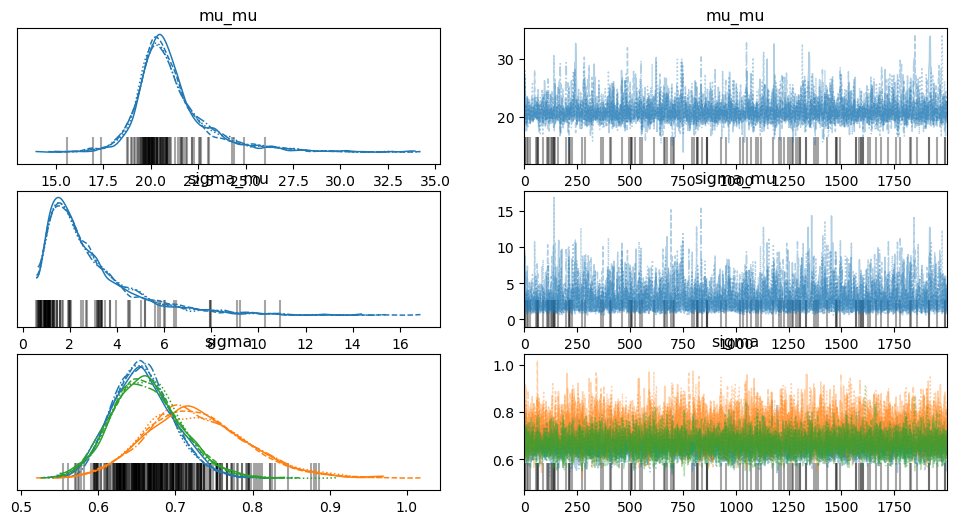

In [185]:
az.plot_trace(trace_3, var_names=["mu_mu", "sigma_mu", "sigma"], compact=True);

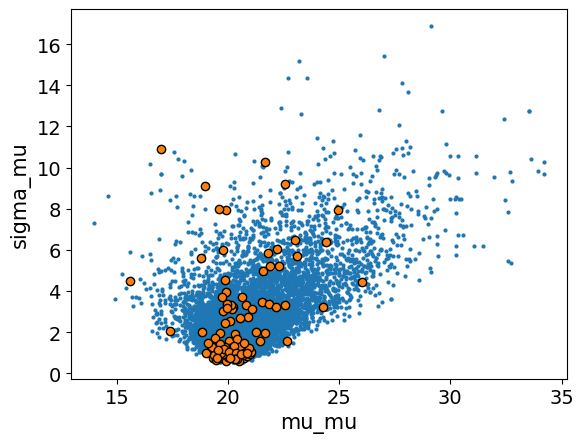

In [186]:
az.plot_pair(trace_3, var_names=['mu_mu', 'sigma_mu'], kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'});

El muestro es malo, entonces quizas el modelo tambien lo sea. Decimos cambiar las distribuciones de los priors y aumentar el target_accept a 0.95

In [187]:
with pm.Model(coords=coords) as model_3:
    mu_mu = pm.Gamma("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Gamma("mu", mu=mu_mu, sigma=sigma_mu, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")

    trace_3 = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True}, progressbar=False, target_accept=0.95)
    trace_3.extend(pm.sample_prior_predictive(samples=100))
    trace_3.extend(pm.sample_posterior_predictive(trace_3));


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [mu, mu_mu, sigma, sigma_mu, y]
Sampling: [y]


Output()

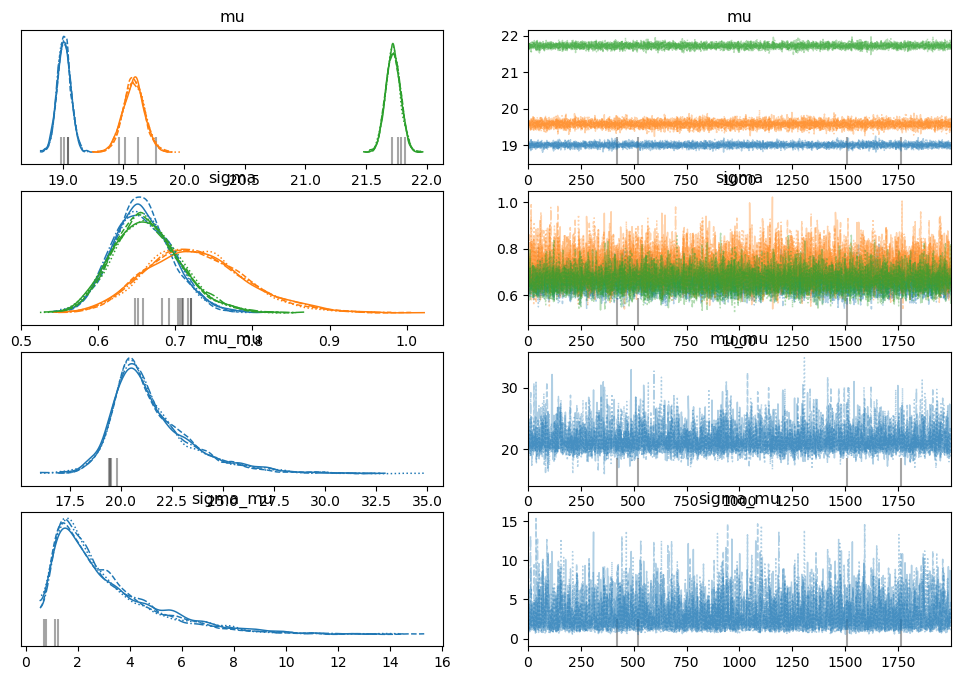

In [188]:
az.plot_trace(trace_3, var_names=["mu","sigma","mu_mu", "sigma_mu"], compact=True);

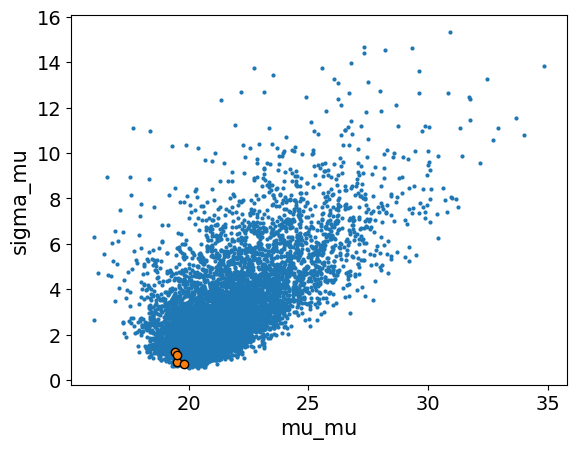

In [189]:
az.plot_pair(trace_3, var_names=['mu_mu', 'sigma_mu'], kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'});

## Prior Predictive Check

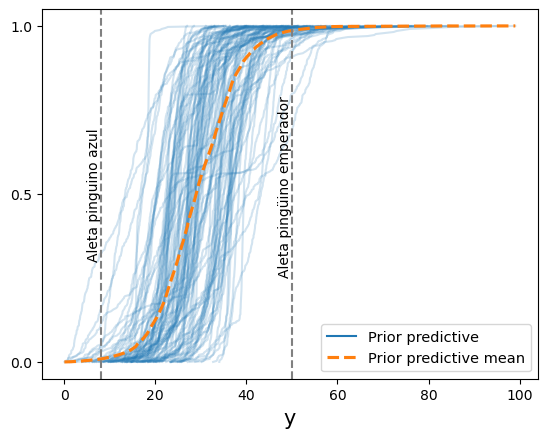

In [190]:
fig, ax = plt.subplots()

az.plot_ppc(trace_3, group="prior", kind="cumulative", ax=ax);

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90)

## Posterior Predictive Check

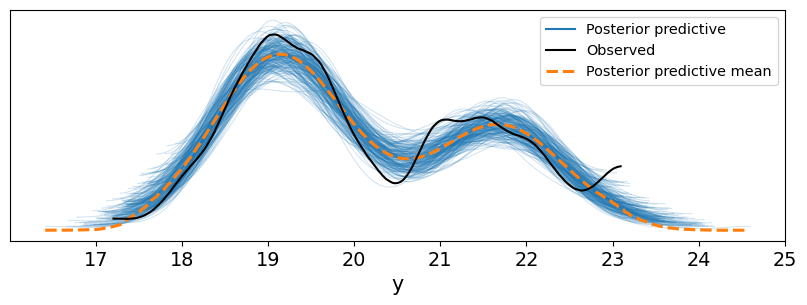

In [191]:
az.plot_ppc(trace_3, figsize=(10, 3), num_pp_samples=200);

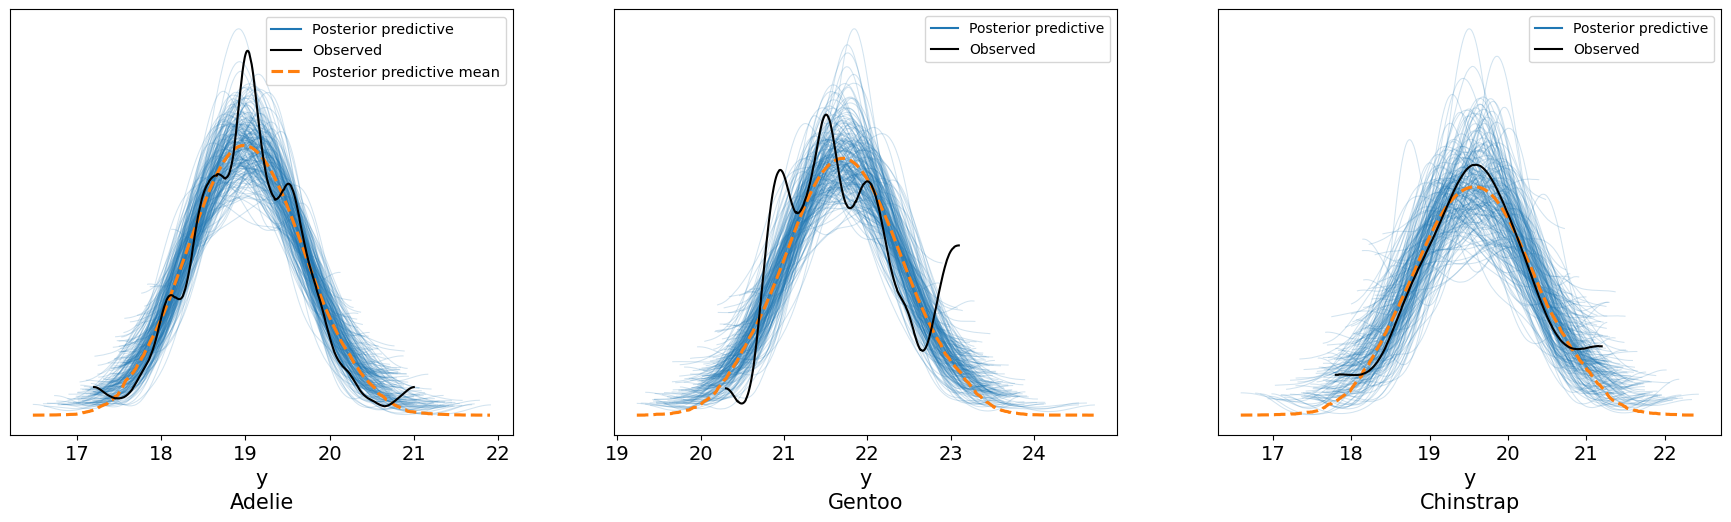

In [192]:
az.plot_ppc(trace_3, coords={"species_flat": [cat_encode.categories]}, flatten=[], num_pp_samples=200);

In [193]:
az.rhat(trace_3, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 1.001 1.001 1.0
    sigma    (species) float64 24B 1.001 1.001 1.0

In [194]:
az.ess(trace_3, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 9.039e+03 9.196e+03 9.418e+03
    sigma    (species) float64 24B 9.471e+03 9.545e+03 9.6e+03

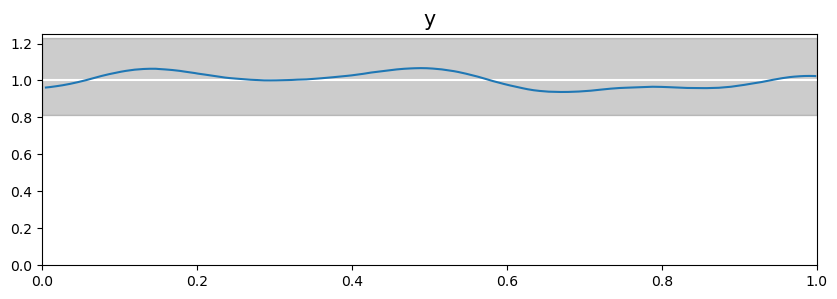

In [195]:
az.plot_bpv(trace_3, figsize=(10, 3));

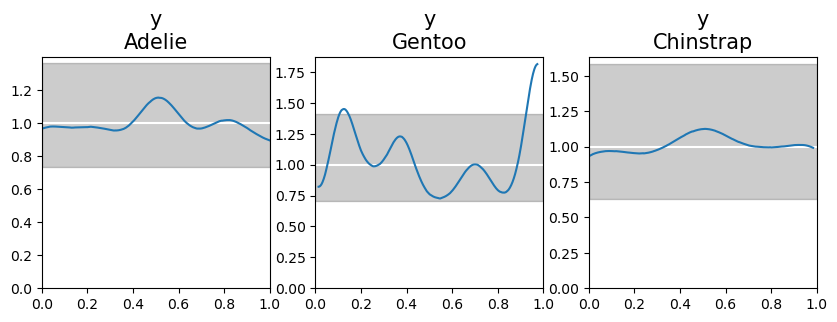

In [196]:
az.plot_bpv(trace_3,coords={"species_flat": [cat_encode.categories]}, flatten=[], figsize=(10, 3));

# Modelo 4: grupos especie-isla

In [197]:
df["species_island"] = df["species"] + " - " + df["island"]

cat_encode = pd.Categorical(df['species_island'])
idx = cat_encode.codes
coords = {"species_island": cat_encode.categories, "species_island_flat": cat_encode.categories[idx]}

In [198]:
with pm.Model(coords=coords) as model_4:
    mu = pm.Normal("mu", mu=29, sigma=5, dims="species_island")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species_island")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_island_flat")
    

In [199]:
with model_4:
    trace_4 = pm.sample_prior_predictive(samples=100)

Sampling: [mu, sigma, y]


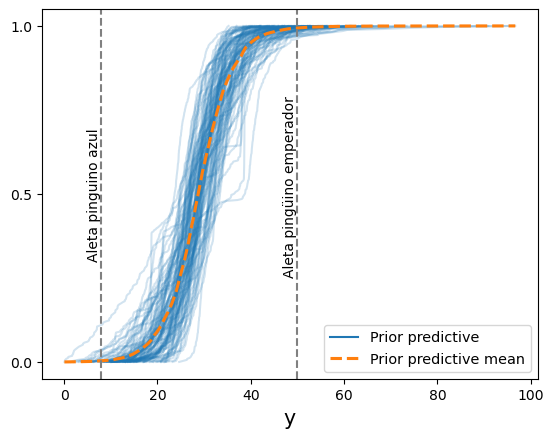

In [200]:
fig, ax = plt.subplots()

az.plot_ppc(trace_4, group="prior", kind="cumulative", figsize=(10, 3), num_pp_samples=100,ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90);

In [201]:
with model_4:
    trace_4 = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_4.extend(pm.sample_posterior_predictive(trace_4));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
Sampling: [y]


Output()

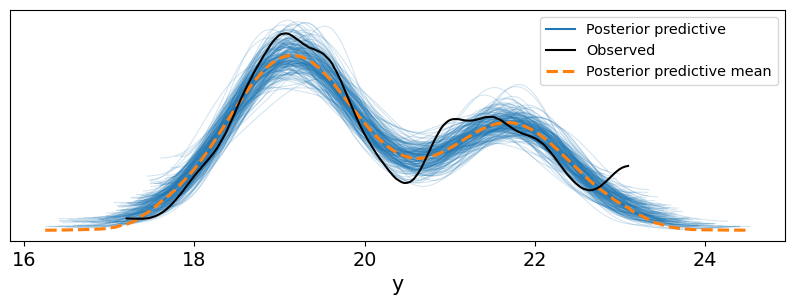

In [202]:
az.plot_ppc(trace_4, figsize=(10, 3), num_pp_samples=200);

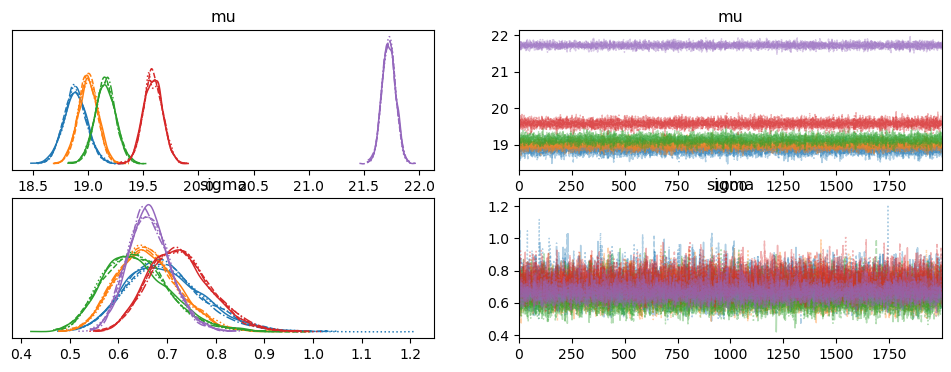

In [203]:
az.plot_trace(trace_4, var_names=["mu", "sigma"], compact=True);

In [204]:
az.rhat(trace_4, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 440B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 1.0 1.002 1.001 1.001 1.001
    sigma           (species_island) float64 40B 1.001 1.0 1.001 1.001 1.0

In [205]:
az.ess(trace_4, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 440B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 9.019e+03 ... 1.105e+04
    sigma           (species_island) float64 40B 9.359e+03 ... 1.097e+04

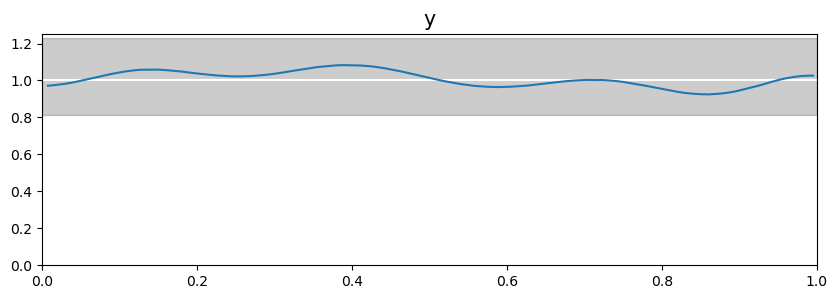

In [206]:
az.plot_bpv(trace_4, figsize=(10, 3));

# Modelo 5: grupos especie-isla jerárquico

In [207]:
with pm.Model(coords=coords) as model_5:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species_island")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species_island")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_island_flat")

In [208]:
with model_5:
    trace_5 = pm.sample_prior_predictive(samples=100)

Sampling: [mu, mu_mu, sigma, sigma_mu, y]


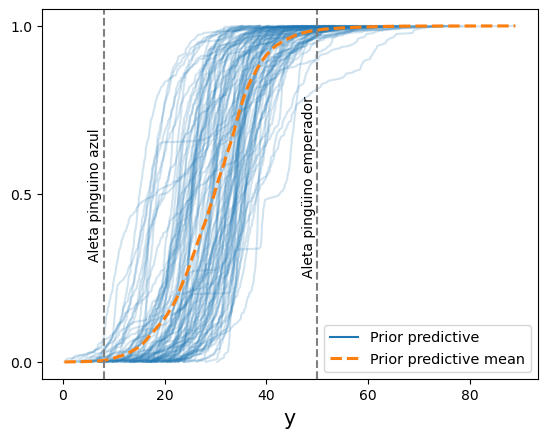

In [209]:
fig, ax = plt.subplots()

az.plot_ppc(trace_5, group="prior", kind="cumulative", figsize=(10, 3), num_pp_samples=100,ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-3, 0.5-(len(key)/100), key, rotation=90);

In [210]:
with model_5:
    trace_5 = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood":True},progressbar=False, target_accept=0.95)
    trace_5.extend(pm.sample_posterior_predictive(trace_5));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Sampling: [y]


Output()

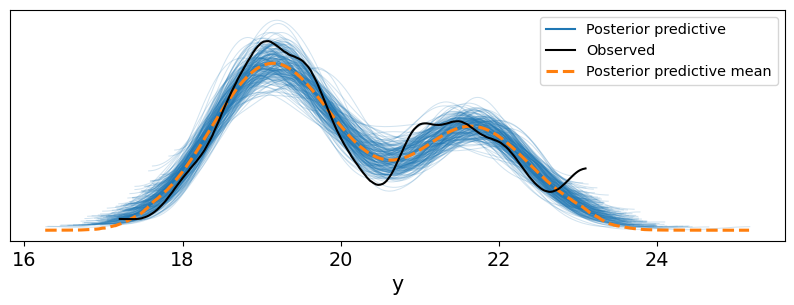

In [211]:
az.plot_ppc(trace_5, figsize=(10, 3), num_pp_samples=200);

## Diagnosticos de muestreo

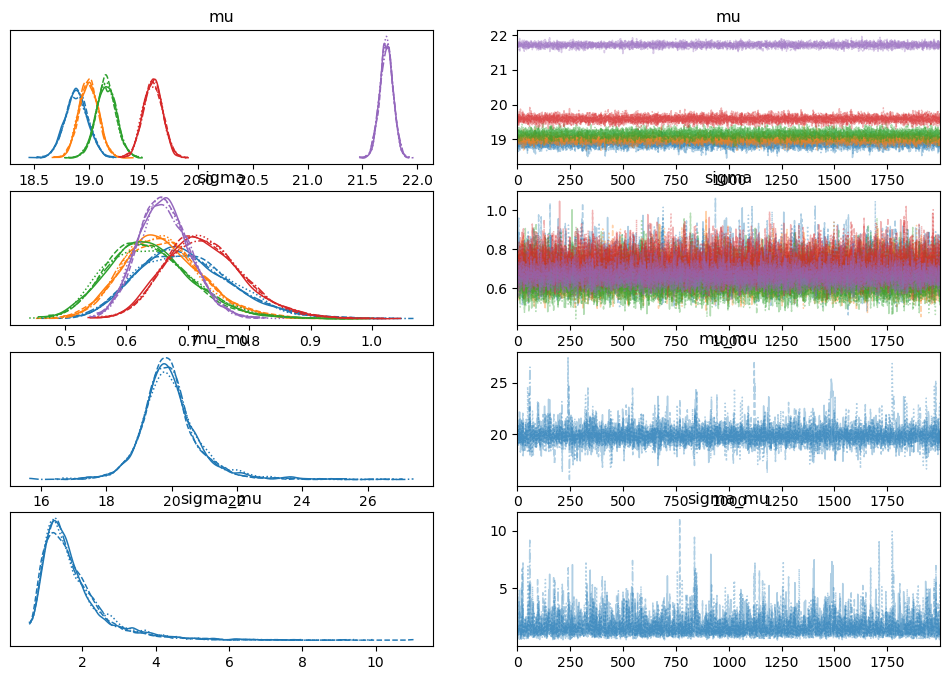

In [212]:
az.plot_trace(trace_5, var_names=["mu", "sigma", "mu_mu", "sigma_mu"], compact=True);

In [213]:
az.rhat(trace_5, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 440B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 1.0 1.001 1.001 1.001 1.001
    sigma           (species_island) float64 40B 1.0 1.0 1.0 1.0 0.9999

In [214]:
az.ess(trace_5, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 440B
Dimensions:         (species_island: 5)
Coordinates:
  * species_island  (species_island) <U18 360B 'Adelie - Biscoe' ... 'Gentoo ...
Data variables:
    mu              (species_island) float64 40B 9.622e+03 7.63e+03 ... 8.31e+03
    sigma           (species_island) float64 40B 9.026e+03 ... 9.933e+03

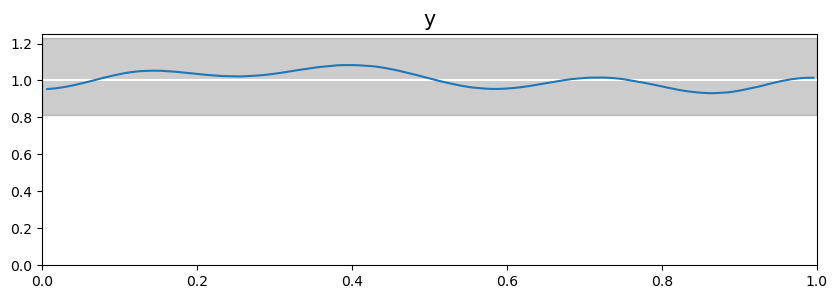

In [215]:
az.plot_bpv(trace_5, figsize=(10, 3));

Con este modelo vimos que se generaban divergencias asique le modificamos los parametros del prior y los hiperpriors, y aumentamos el target_accept a 0.9. 

## Comparacion de modelo

In [216]:
az.compare({"model_1":trace_1, "model_2":trace_2, "model_3":trace_3, "model_4":trace_4, "model_5":trace_5})

rank    elpd_loo     p_loo   elpd_diff        weight         se  \
model_2     0 -341.414120  5.671375    0.000000  9.709659e-01  12.627560   
model_3     1 -341.437551  5.687455    0.023431  0.000000e+00  12.633810   
model_5     2 -343.544469  9.825358    2.130349  2.903409e-02  12.723848   
model_4     3 -343.604590  9.875397    2.190471  1.441298e-14  12.695011   
model_1     4 -583.537308  1.512886  242.123188  0.000000e+00   9.397556   

               dse  warning scale  
model_2   0.000000    False   log  
model_3   0.052284    False   log  
model_5   2.160421    False   log  
model_4   2.182390    False   log  
model_1  12.512378    False   log

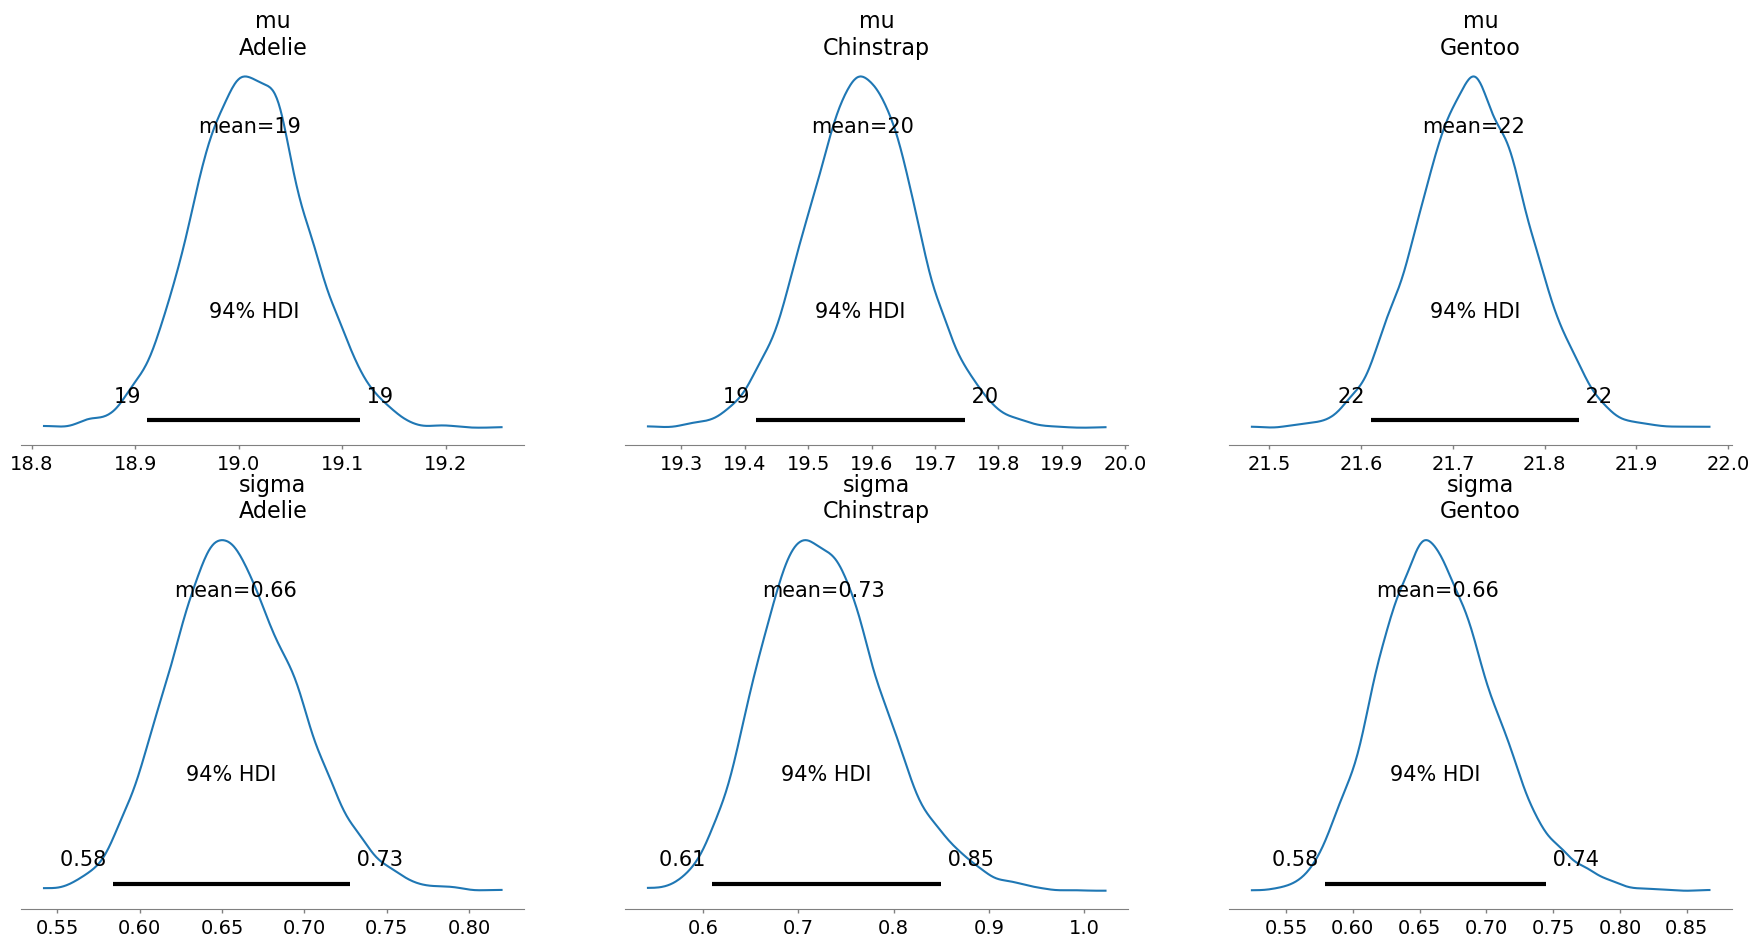

In [217]:
az.plot_posterior(trace_3, var_names=["mu", "sigma"]);